In [139]:
# Core libraries
import pandas as pd
import numpy as np
import gzip
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import LabelEncoder, quantile_transform

# For batch correction
# Install: pip install combat

# Set display options
pd.set_option('display.max_columns', 20)

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports complete!")

Imports complete!


In [140]:
#%pip install combat

In [141]:
# Load ADNI Data

import gzip

# Load Phenotype Data - need to stop before expression data starts
print("Loading ADNI phenotype data...")

pheno_rows = []
with gzip.open('data/ADNI/ADNI_GEO_formatted.csv.gz', 'rt') as f:
    in_pheno_section = False
    for line in f:
        if '!Sample_phenotype_section' in line:
            in_pheno_section = True
            continue
        if line.startswith('!') and in_pheno_section and 'phenotype' not in line.lower():
            break  # Hit next section
        if in_pheno_section and line.strip() and not line.startswith('!'):
            parts = line.strip().split(',')
            if len(parts) == 5:  # Only phenotype rows have exactly 5 columns
                pheno_rows.append(parts)

adni_pheno = pd.DataFrame(pheno_rows[1:], columns=pheno_rows[0])
adni_pheno['AGE'] = pd.to_numeric(adni_pheno['AGE'], errors='coerce')

print(f"ADNI Phenotype shape: {adni_pheno.shape}")
print(f"\nDiagnosis distribution:")
print(adni_pheno['Diagnosis'].value_counts())

# Load Expression Data
print("\nLoading ADNI expression data...")

adni_expr = pd.read_csv('data/ADNI/ADNI_combined_dataset.csv.gz', compression='gzip')
adni_expr = adni_expr.set_index('PTID')
adni_expr = adni_expr.apply(pd.to_numeric, errors='coerce')

print(f"\nExpression value range: {np.nanmin(adni_expr.values):.2f} to {np.nanmax(adni_expr.values):.2f}")

print(f"ADNI Expression shape: {adni_expr.shape}")
print(f"Sample IDs: {adni_expr.index[:5].tolist()}")
print(f"Number of probes/genes: {adni_expr.shape[1]}")
print(f"\nExpression value range: {adni_expr.values.min():.2f} to {adni_expr.values.max():.2f}")

# Merge phenotype with expression
print("\nMerging phenotype and expression...")

common_ids = set(adni_pheno['PTID']).intersection(set(adni_expr.index))
print(f"Samples in phenotype: {len(adni_pheno)}")
print(f"Samples in expression: {len(adni_expr)}")
print(f"Common samples: {len(common_ids)}")

adni_pheno = adni_pheno[adni_pheno['PTID'].isin(common_ids)].copy()
adni_expr = adni_expr.loc[adni_expr.index.isin(common_ids)].copy()

print(f"\nFinal ADNI samples: {len(adni_pheno)}")
print(f"Final diagnosis distribution:")
print(adni_pheno['Diagnosis'].value_counts())

Loading ADNI phenotype data...
ADNI Phenotype shape: (744, 5)

Diagnosis distribution:
Diagnosis
MCI        439
Control    261
            44
Name: count, dtype: int64

Loading ADNI expression data...

Expression value range: -100.00 to 2072470.00
ADNI Expression shape: (744, 48274)
Sample IDs: ['009_S_4612', '114_S_0416', '128_S_1407', '072_S_4610', '033_S_1116']
Number of probes/genes: 48274

Expression value range: nan to nan

Merging phenotype and expression...
Samples in phenotype: 744
Samples in expression: 744
Common samples: 744

Final ADNI samples: 744
Final diagnosis distribution:
Diagnosis
MCI        439
Control    261
            44
Name: count, dtype: int64


In [142]:
# Clean ADNI Data

# Check the empty diagnoses
print("Samples with empty diagnosis:", (adni_pheno['Diagnosis'] == '').sum())
print("Samples with valid diagnosis:", (adni_pheno['Diagnosis'] != '').sum())

# Remove samples with empty diagnosis
adni_pheno = adni_pheno[adni_pheno['Diagnosis'] != ''].copy()

# Update expression to match
adni_expr = adni_expr.loc[adni_expr.index.isin(adni_pheno['PTID'])].copy()

# Verify alignment
adni_pheno = adni_pheno.set_index('PTID')
adni_expr = adni_expr.loc[adni_pheno.index]  # Align order

print(f"\nAfter cleaning:")
print(f"ADNI Phenotype shape: {adni_pheno.shape}")
print(f"ADNI Expression shape: {adni_expr.shape}")
print(f"\nDiagnosis distribution:")
print(adni_pheno['Diagnosis'].value_counts())
print(f"\nIndex aligned: {(adni_pheno.index == adni_expr.index).all()}")

Samples with empty diagnosis: 44
Samples with valid diagnosis: 700

After cleaning:
ADNI Phenotype shape: (700, 4)
ADNI Expression shape: (700, 48274)

Diagnosis distribution:
Diagnosis
MCI        439
Control    261
Name: count, dtype: int64

Index aligned: True


In [143]:
# Load GSE63060

def parse_geo_series_matrix(filepath):
    """Parse GEO series matrix file to extract phenotype and expression data"""
    
    pheno_data = {}
    expr_lines = []
    sample_ids = []
    in_table = False
    
    with gzip.open(filepath, 'rt') as f:
        for line in f:
            line = line.strip()
            
            if line.startswith('!Sample_geo_accession'):
                sample_ids = line.split('\t')[1:]
                sample_ids = [s.strip('"') for s in sample_ids]
            
            elif line.startswith('!Sample_characteristics_ch1'):
                parts = line.split('\t')[1:]
                parts = [p.strip('"') for p in parts]
                
                if len(parts) > 0 and ':' in parts[0]:
                    key = parts[0].split(':')[0].strip()
                    values = [p.split(':')[1].strip() if ':' in p else p for p in parts]
                    
                    if key not in pheno_data:
                        pheno_data[key] = values
            
            elif line.startswith('!Sample_title'):
                parts = line.split('\t')[1:]
                pheno_data['title'] = [p.strip('"') for p in parts]
            
            elif line == '!series_matrix_table_begin':
                in_table = True
                continue
            elif line == '!series_matrix_table_end':
                in_table = False
                continue
            
            if in_table and line:
                expr_lines.append(line)
    
    pheno_df = pd.DataFrame(pheno_data)
    pheno_df['Sample_ID'] = sample_ids
    pheno_df = pheno_df.set_index('Sample_ID')
    
    expr_data = []
    probe_ids = []
    
    header = expr_lines[0].split('\t')
    expr_sample_ids = [s.strip('"') for s in header[1:]]
    
    for line in expr_lines[1:]:
        parts = line.split('\t')
        probe_id = parts[0].strip('"')
        values = [float(v) if v not in ['', 'null', 'NA'] else np.nan for v in parts[1:]]
        probe_ids.append(probe_id)
        expr_data.append(values)
    
    expr_df = pd.DataFrame(expr_data, index=probe_ids, columns=expr_sample_ids)
    expr_df = expr_df.T
    
    return pheno_df, expr_df

print("Loading GSE63060...")
gse63060_pheno, gse63060_expr = parse_geo_series_matrix('data/GSE/GSE63060_series_matrix.txt.gz')

print(f"GSE63060 Phenotype shape: {gse63060_pheno.shape}")
print(f"GSE63060 Expression shape: {gse63060_expr.shape}")
print(f"\nPhenotype columns: {gse63060_pheno.columns.tolist()}")
print(f"\nFirst few rows of phenotype:")
print(gse63060_pheno.head())

Loading GSE63060...
GSE63060 Phenotype shape: (329, 7)
GSE63060 Expression shape: (329, 38323)

Phenotype columns: ['title', 'status', 'ethnicity', 'age', 'gender', 'included in case -control study', 'tissue']

First few rows of phenotype:
                   title status         ethnicity age  gender  \
Sample_ID                                                       
GSM1539080  4856050008_I    MCI  Western European  65  Female   
GSM1539081  4856050047_D    MCI   Other Caucasian  66  Female   
GSM1539082  4856076009_D    MCI  Western European  67  Female   
GSM1539083  4856076040_F    MCI           Unknown  67  Female   
GSM1539084  4856076002_E    MCI  Western European  67  Female   

           included in case -control study tissue  
Sample_ID                                          
GSM1539080                             yes  blood  
GSM1539081                             yes  blood  
GSM1539082                             yes  blood  
GSM1539083                             yes  

In [144]:
# Clean GSE63060

print("GSE63060 diagnosis distribution:")
print(gse63060_pheno['status'].value_counts())

# Rename columns to match ADNI format
gse63060_pheno = gse63060_pheno.rename(columns={
    'status': 'Diagnosis',
    'age': 'AGE',
    'gender': 'PTGENDER'
})

# Standardize diagnosis labels
diagnosis_map = {
    'MCI': 'MCI',
    'CTL': 'Control',
    'AD': 'AD'
}
gse63060_pheno['Diagnosis'] = gse63060_pheno['Diagnosis'].map(diagnosis_map)

# Convert age to numeric
gse63060_pheno['AGE'] = pd.to_numeric(gse63060_pheno['AGE'], errors='coerce')

# Check for missing diagnoses
print(f"\nAfter cleaning:")
print(f"Missing diagnoses: {gse63060_pheno['Diagnosis'].isna().sum()}")
print(f"\nDiagnosis distribution:")
print(gse63060_pheno['Diagnosis'].value_counts())

# Check expression value range
print(f"\nExpression value range: {gse63060_expr.values.min():.2f} to {gse63060_expr.values.max():.2f}")

GSE63060 diagnosis distribution:
status
AD     145
CTL    104
MCI     80
Name: count, dtype: int64

After cleaning:
Missing diagnoses: 0

Diagnosis distribution:
Diagnosis
AD         145
Control    104
MCI         80
Name: count, dtype: int64

Expression value range: 7.20 to 15.05


In [171]:
# Load GSE85426 expression data

# Check file structure first
print("Checking GSE85426_normalized_data.txt structure...")

with open('data/GSE/GSE85426_normalized_data.txt', 'r') as f:
    for i, line in enumerate(f):
        print(f"{i}: {line[:120]}")
        if i >= 10:
            break

print("\n...")

# Check total lines
with open('data/GSE/GSE85426_normalized_data.txt', 'r') as f:
    total_lines = sum(1 for _ in f)
print(f"\nTotal lines: {total_lines}")

Checking GSE85426_normalized_data.txt structure...
0: Gene_ID	US81403231_252800417012_S01_GE1_107_Sep09_1_1.txt	US81403231_252800417012_S01_GE1_107_Sep09_1_2.txt	US81403231_2
1: A_19_P00328650	-0.12671566	-0.08836079	1.1169977	-4.097625	-2.030262	-1.7054853	-0.4100628	0.6649456	0.37057304	-0.41006
2: A_19_P00803901	0.7002783	-0.1519928	1.9784145	-4.58344	-2.003768	-1.3851118	0.21695232	2.022605	0.47995186	-1.7848463	-3
3: A_19_P00322400	0.41957664	0.4588995	1.2527161	-2.848709	-1.9593592	-1.2145767	0.2994089	0.5969572	0.4264698	-0.52815247	
4: A_19_P00812377	0.5042753	0.12817001	1.6858063	-3.396266	-2.3281946	-1.5912218	0.11796951	1.2503557	0.62345314	-0.3860139
5: A_19_P00805814	0.2923994	0.2059288	1.1941586	-3.308958	-1.0663309	-0.65496635	0.23110104	0.8428049	0.49047565	-0.3419656
6: A_19_P00325706	0.5888481	-0.76156235	1.7662249	-4.4018316	-2.1405602	-1.5012932	-0.09001255	2.0057106	0.29361534	-0.9176
7: A_33_P3337742	0.51115894	-0.49972725	1.178132	-4.6711874	-1.7989426	-1.6982737

In [172]:
# Load GSE85426 expression data

gse85426_expr_raw = pd.read_csv('data/GSE/GSE85426_normalized_data.txt', sep='\t', index_col=0)
print(f"GSE85426 expression shape: {gse85426_expr_raw.shape}")
print(f"Sample columns (first 3): {gse85426_expr_raw.columns[:3].tolist()}")
print(f"Probe IDs (first 5): {gse85426_expr_raw.index[:5].tolist()}")

# The column names are file names, need to map to GSM IDs
# Check the series matrix for mapping
print("\nLooking for sample ID mapping in series matrix...")

sample_mapping = {}
with gzip.open('data/GSE/GSE85426_series_matrix.txt.gz', 'rt') as f:
    for line in f:
        if line.startswith('!Sample_geo_accession'):
            gsm_ids = [s.strip('"') for s in line.strip().split('\t')[1:]]
        if line.startswith('!Sample_supplementary_file'):
            files = [s.strip('"').split('/')[-1] for s in line.strip().split('\t')[1:]]
            if len(files) == len(gsm_ids):
                for gsm, fname in zip(gsm_ids, files):
                    # Extract core filename pattern
                    sample_mapping[fname] = gsm

print(f"Found {len(sample_mapping)} sample mappings")
print(f"Example mapping: {list(sample_mapping.items())[:2]}")

GSE85426 expression shape: (14113, 180)
Sample columns (first 3): ['US81403231_252800417012_S01_GE1_107_Sep09_1_1.txt', 'US81403231_252800417012_S01_GE1_107_Sep09_1_2.txt', 'US81403231_252800417012_S01_GE1_107_Sep09_1_4.txt']
Probe IDs (first 5): ['A_19_P00328650', 'A_19_P00803901', 'A_19_P00322400', 'A_19_P00812377', 'A_19_P00805814']

Looking for sample ID mapping in series matrix...
Found 1 sample mappings
Example mapping: [('NONE', 'GSM2266789')]


In [173]:
# Find GSE85426 sample mapping

# Check all relevant fields in series matrix
with gzip.open('data/GSE/GSE85426_series_matrix.txt.gz', 'rt') as f:
    for line in f:
        if line.startswith('!Sample_geo_accession'):
            gsm_ids = [s.strip('"') for s in line.strip().split('\t')[1:]]
            print(f"GSM IDs ({len(gsm_ids)}): {gsm_ids[:3]}")
        if line.startswith('!Sample_title'):
            titles = [s.strip('"') for s in line.strip().split('\t')[1:]]
            print(f"Titles ({len(titles)}): {titles[:3]}")
        if line.startswith('!Sample_source_name'):
            sources = [s.strip('"') for s in line.strip().split('\t')[1:]]
            print(f"Sources ({len(sources)}): {sources[:3]}")
        if line.startswith('!Sample_description'):
            descs = [s.strip('"') for s in line.strip().split('\t')[1:]]
            print(f"Descriptions ({len(descs)}): {descs[:3]}")

# Check if column names in expression data have any pattern
expr_cols = gse85426_expr_raw.columns.tolist()
print(f"\nExpression columns ({len(expr_cols)}): {expr_cols[:3]}")

# Both have 180 samples - assume they're in the same order
print(f"\nBoth have 180 samples. Assuming same order...")

Titles (180): ['Non-demented control 1', 'Probable AD 1', 'Probable AD 2']
GSM IDs (180): ['GSM2266610', 'GSM2266611', 'GSM2266612']
Sources (180): ['Peripheral Blood, replicate 1', 'Peripheral Blood, replicate 1', 'Peripheral Blood, replicate 1']
Descriptions (180): ['Gene expression of non-demented contol subject using human blood', "Gene expression of Alzheimer's disease patient using human blood", "Gene expression of Alzheimer's disease patient using human blood"]
Descriptions (180): ['US81403231_252800416103_S01_GE1_107_Sep09_1_1', 'US81403231_252800416103_S01_GE1_107_Sep09_1_2', 'US81403231_252800416103_S01_GE1_107_Sep09_1_3']

Expression columns (180): ['US81403231_252800417012_S01_GE1_107_Sep09_1_1.txt', 'US81403231_252800417012_S01_GE1_107_Sep09_1_2.txt', 'US81403231_252800417012_S01_GE1_107_Sep09_1_4.txt']

Both have 180 samples. Assuming same order...


In [174]:
# Map GSE85426 samples using description field

# Get the descriptions (filenames) from series matrix
with gzip.open('data/GSE/GSE85426_series_matrix.txt.gz', 'rt') as f:
    gsm_ids = None
    desc_filenames = None
    for line in f:
        if line.startswith('!Sample_geo_accession'):
            gsm_ids = [s.strip('"') for s in line.strip().split('\t')[1:]]
        if line.startswith('!Sample_description'):
            parts = [s.strip('"') for s in line.strip().split('\t')[1:]]
            # Check if this line contains filenames (starts with US)
            if parts[0].startswith('US'):
                desc_filenames = parts

print(f"GSM IDs: {len(gsm_ids)}, Description filenames: {len(desc_filenames)}")

# Create mapping from filename base to GSM ID
# Expression columns have .txt suffix, descriptions don't
desc_to_gsm = {}
for gsm, desc in zip(gsm_ids, desc_filenames):
    desc_to_gsm[desc + '.txt'] = gsm
    desc_to_gsm[desc] = gsm

# Try to match expression columns
expr_cols = gse85426_expr_raw.columns.tolist()
matched = 0
unmatched_examples = []

for col in expr_cols:
    if col in desc_to_gsm:
        matched += 1
    else:
        unmatched_examples.append(col)

print(f"Directly matched: {matched}/{len(expr_cols)}")

if matched == 0:
    # Different approach - extract common pattern and match by position suffix
    print("\nTrying pattern matching...")
    print(f"Expr col example: {expr_cols[0]}")
    print(f"Desc example:     {desc_filenames[0]}")
    
    # Extract the ending pattern (like _1_1, _1_2, etc.)
    def get_suffix(s):
        parts = s.replace('.txt', '').split('_')
        return '_'.join(parts[-2:])  # Last two parts
    
    expr_suffixes = [get_suffix(c) for c in expr_cols]
    desc_suffixes = [get_suffix(d) for d in desc_filenames]
    
    print(f"\nExpr suffixes: {expr_suffixes[:5]}")
    print(f"Desc suffixes: {desc_suffixes[:5]}")

GSM IDs: 180, Description filenames: 180
Directly matched: 180/180


In [179]:
# Reload GSE85426 phenotype from scratch
with gzip.open('data/GSE/GSE85426_series_matrix.txt.gz', 'rt') as f:
    for line in f:
        if line.startswith('!Sample_geo_accession'):
            gsm_ids = [s.strip('"') for s in line.strip().split('\t')[1:]]
        if line.startswith('!Sample_title'):
            titles = [s.strip('"') for s in line.strip().split('\t')[1:]]
        if line.startswith('!Sample_characteristics_ch1\t"diagnosis:'):
            diagnoses = [s.strip('"').replace('diagnosis: ', '') for s in line.strip().split('\t')[1:]]
        if line.startswith('!Sample_characteristics_ch1\t"age:'):
            ages = [s.strip('"').replace('age: ', '') for s in line.strip().split('\t')[1:]]
        if line.startswith('!Sample_characteristics_ch1\t"gender:'):
            genders = [s.strip('"').replace('gender: ', '') for s in line.strip().split('\t')[1:]]

gse85426_pheno = pd.DataFrame({
    'title': titles,
    'diagnosis': diagnoses,
    'age': ages,
    'gender': genders
}, index=gsm_ids)

print("Raw diagnosis values:")
print(gse85426_pheno['diagnosis'].unique())

# Now rename and map
gse85426_pheno = gse85426_pheno.rename(columns={
    'diagnosis': 'Diagnosis',
    'age': 'AGE', 
    'gender': 'PTGENDER'
})

gse85426_pheno['AGE'] = pd.to_numeric(gse85426_pheno['AGE'], errors='coerce')

gse85426_pheno['Diagnosis'] = gse85426_pheno['Diagnosis'].replace({
    'Non-demented control': 'Control',
    "Probable Alzheimer's Disease": 'AD'
})

print(f"\nGSE85426 diagnosis distribution:")
print(gse85426_pheno['Diagnosis'].value_counts())

Raw diagnosis values:
['Non-demented control' "Probable Alzheimer's Disease"]

GSE85426 diagnosis distribution:
Diagnosis
Control    90
AD         90
Name: count, dtype: int64


In [180]:
# Complete GSE85426 loading

# Rename columns from filenames to GSM IDs
gse85426_expr = gse85426_expr_raw.rename(columns=desc_to_gsm)
gse85426_expr = gse85426_expr.T  # Samples as rows

print(f"GSE85426 expression shape: {gse85426_expr.shape}")
print(f"Sample IDs: {gse85426_expr.index[:5].tolist()}")

# Verify alignment with phenotype
common_samples = set(gse85426_pheno.index).intersection(set(gse85426_expr.index))
print(f"\nSamples in phenotype: {len(gse85426_pheno)}")
print(f"Samples in expression: {len(gse85426_expr)}")
print(f"Common samples: {len(common_samples)}")

# Align
gse85426_expr = gse85426_expr.loc[gse85426_pheno.index]

# Check current column names
print(f"\nCurrent phenotype columns: {gse85426_pheno.columns.tolist()}")

# Only rename if not already renamed
if 'diagnosis' in gse85426_pheno.columns:
    gse85426_pheno = gse85426_pheno.rename(columns={
        'diagnosis': 'Diagnosis',
        'age': 'AGE',
        'gender': 'PTGENDER'
    })

gse85426_pheno['AGE'] = pd.to_numeric(gse85426_pheno['AGE'], errors='coerce')

# Standardize diagnosis - use replace instead of map (safer for re-runs)
gse85426_pheno['Diagnosis'] = gse85426_pheno['Diagnosis'].replace({
    'Non-demented control': 'Control',
    "Probable Alzheimer's Disease": 'AD'
})

print(f"\nGSE85426 diagnosis distribution:")
print(gse85426_pheno['Diagnosis'].value_counts())

print(f"\nExpression value range: {gse85426_expr.values.min():.2f} to {gse85426_expr.values.max():.2f}")
print(f"Index aligned: {(gse85426_pheno.index == gse85426_expr.index).all()}")

GSE85426 expression shape: (180, 14113)
Sample IDs: ['GSM2266637', 'GSM2266638', 'GSM2266640', 'GSM2266641', 'GSM2266642']

Samples in phenotype: 180
Samples in expression: 180
Common samples: 180

Current phenotype columns: ['title', 'Diagnosis', 'AGE', 'PTGENDER']

GSE85426 diagnosis distribution:
Diagnosis
Control    90
AD         90
Name: count, dtype: int64

Expression value range: -10.60 to 12.00
Index aligned: True


In [181]:
# Dataset summary

# First, ensure all expression data is numeric
adni_expr = adni_expr.apply(pd.to_numeric, errors='coerce')
gse63060_expr = gse63060_expr.apply(pd.to_numeric, errors='coerce')
gse85426_expr = gse85426_expr.apply(pd.to_numeric, errors='coerce')

print("DATASET SUMMARY")

print("\nADNI:")
print(f"  Samples: {adni_expr.shape[0]}")
print(f"  Probes/Genes: {adni_expr.shape[1]}")
print(f"  Platform: Affymetrix")
print(f"  Expression range: {np.nanmin(adni_expr.values):.2f} to {np.nanmax(adni_expr.values):.2f}")
print(f"  Diagnosis: {dict(adni_pheno['Diagnosis'].value_counts())}")

print("\nGSE63060:")
print(f"  Samples: {gse63060_expr.shape[0]}")
print(f"  Probes/Genes: {gse63060_expr.shape[1]}")
print(f"  Platform: Illumina HumanHT-12")
print(f"  Expression range: {np.nanmin(gse63060_expr.values):.2f} to {np.nanmax(gse63060_expr.values):.2f}")
print(f"  Diagnosis: {dict(gse63060_pheno['Diagnosis'].value_counts())}")

print("\nGSE85426:")
print(f"  Samples: {gse85426_expr.shape[0]}")
print(f"  Probes/Genes: {gse85426_expr.shape[1]}")
print(f"  Platform: Agilent SurePrint G3")
print(f"  Expression range: {np.nanmin(gse85426_expr.values):.2f} to {np.nanmax(gse85426_expr.values):.2f}")
print(f"  Diagnosis: {dict(gse85426_pheno['Diagnosis'].value_counts())}")

print("COMBINED (after merging):")
total_samples = adni_expr.shape[0] + gse63060_expr.shape[0] + gse85426_expr.shape[0]
print(f"  Total samples: {total_samples}")
print(f"  AD: {145 + 90} (GSE63060 + GSE85426)")
print(f"  MCI: {439 + 80} (ADNI + GSE63060)")
print(f"  Control: {261 + 104 + 90} (ADNI + GSE63060 + GSE85426)")

DATASET SUMMARY

ADNI:
  Samples: 700
  Probes/Genes: 48274
  Platform: Affymetrix
  Expression range: 0.00 to 20.98
  Diagnosis: {'MCI': 439, 'Control': 261}

GSE63060:
  Samples: 329
  Probes/Genes: 38323
  Platform: Illumina HumanHT-12
  Expression range: 7.20 to 15.05
  Diagnosis: {'AD': 145, 'Control': 104, 'MCI': 80}

GSE85426:
  Samples: 180
  Probes/Genes: 14113
  Platform: Agilent SurePrint G3
  Expression range: -10.60 to 12.00
  Diagnosis: {'Control': 90, 'AD': 90}
COMBINED (after merging):
  Total samples: 1209
  AD: 235 (GSE63060 + GSE85426)
  MCI: 519 (ADNI + GSE63060)
  Control: 455 (ADNI + GSE63060 + GSE85426)


In [182]:
# Log2 transform ADNI

print("ADNI expression before transform:")
print(f"  Min: {np.nanmin(adni_expr.values):.2f}")
print(f"  Max: {np.nanmax(adni_expr.values):.2f}")
print(f"  Median: {np.nanmedian(adni_expr.values):.2f}")

# Check for negative values
neg_count = (adni_expr.values < 0).sum()
print(f"  Negative values: {neg_count}")

# Handle negative values by shifting, then log2 transform
# Standard approach: log2(x + 1) or log2(x - min + 1)
min_val = np.nanmin(adni_expr.values)

if min_val <= 0:
    shift = abs(min_val) + 1
    print(f"\nShifting by {shift:.2f} to handle negative/zero values")
    adni_expr_log = np.log2(adni_expr + shift)
else:
    adni_expr_log = np.log2(adni_expr + 1)

adni_expr = adni_expr_log

print("\nADNI expression after log2 transform:")
print(f"  Min: {np.nanmin(adni_expr.values):.2f}")
print(f"  Max: {np.nanmax(adni_expr.values):.2f}")
print(f"  Median: {np.nanmedian(adni_expr.values):.2f}")

ADNI expression before transform:
  Min: 0.00
  Max: 20.98
  Median: 6.71
  Negative values: 0

Shifting by 1.00 to handle negative/zero values

ADNI expression after log2 transform:
  Min: 0.00
  Max: 4.46
  Median: 2.95


In [183]:
# Map ADNI probes to gene symbols

# ADNI columns already have gene symbols embedded (e.g., "HIST1H3G_11715100_at")
# Extract just the gene symbol

adni_genes = []
for col in adni_expr.columns:
    # Format is GENESYMBOL_PROBEID_at or similar
    parts = col.split('_')
    if len(parts) >= 2:
        # Gene symbol is everything before the numeric probe ID
        gene = parts[0]
        # Handle cases like "CTAGE6 || CTAGE15_11715106_x_at"
        if '||' in col:
            gene = col.split('_')[0].split('||')[0].strip()
        adni_genes.append(gene)
    else:
        adni_genes.append(col)

# Create mapping dataframe
adni_gene_map = pd.DataFrame({
    'probe': adni_expr.columns,
    'gene': adni_genes
})

print(f"ADNI probe-gene mapping:")
print(f"  Total probes: {len(adni_gene_map)}")
print(f"  Unique genes: {adni_gene_map['gene'].nunique()}")
print(f"\nExample mappings:")
print(adni_gene_map.head(10))

# Check for empty or problematic gene symbols
print(f"\nEmpty gene symbols: {(adni_gene_map['gene'] == '').sum()}")
print(f"Genes starting with number: {adni_gene_map['gene'].str.match(r'^\d').sum()}")

ADNI probe-gene mapping:
  Total probes: 48274
  Unique genes: 19737

Example mappings:
                                probe       gene
0                HIST1H3G_11715100_at   HIST1H3G
1              HIST1H3G_11715101_s_at   HIST1H3G
2              HIST1H3G_11715102_x_at   HIST1H3G
3             TNFAIP8L1_11715103_x_at  TNFAIP8L1
4                 OTOP2_11715104_s_at      OTOP2
5                C17ORF78_11715105_at   C17ORF78
6     CTAGE6 || CTAGE15_11715106_x_at     CTAGE6
7  F8A2 || F8A3 || F8A1_11715107_s_at       F8A2
8             LINC01098_11715108_x_at  LINC01098
9                   SAMD7_11715109_at      SAMD7

Empty gene symbols: 0
Genes starting with number: 84


In [184]:
# Map GSE63060 probes to gene symbols using GPL6947

gpl6947 = pd.read_csv('data/GSE/GPL6947_annotation.csv')

print(f"GPL6947 annotation shape: {gpl6947.shape}")
print(f"Columns: {gpl6947.columns.tolist()}")
print(f"\nFirst few rows:")
print(gpl6947.head())

GPL6947 annotation shape: (29276, 22)
Columns: ['ID', 'Gene title', 'Gene symbol', 'Gene ID', 'UniGene title', 'UniGene symbol', 'UniGene ID', 'Nucleotide Title', 'GI', 'GenBank Accession', 'Platform_CLONEID', 'Platform_ORF', 'Platform_SPOTID', 'Chromosome location', 'Chromosome annotation', 'GO:Function', 'GO:Process', 'GO:Component', 'GO:Function ID', 'GO:Process ID', 'GO:Component ID', 'Platform_SEQUENCE']

First few rows:
             ID                              Gene title Gene symbol Gene ID  \
0  ILMN_1910180                            neuropilin 2        NRP2    8828   
1  ILMN_1804174         Fc fragment of IgG receptor IIb      FCGR2B    2213   
2  ILMN_1796063          tripartite motif containing 44      TRIM44   54765   
3  ILMN_1668162  acyl-CoA wax alcohol acyltransferase 1       AWAT1  158833   
4  ILMN_1912287                    succinate receptor 1      SUCNR1   56670   

  UniGene title UniGene symbol UniGene ID  \
0           NaN            NaN        NaN   
1    

In [185]:
# Create GSE63060 probe-gene mapping

# Create mapping dictionary from probe ID to gene symbol
gpl6947_map = gpl6947[['ID', 'Gene symbol']].dropna()
gpl6947_map = gpl6947_map[gpl6947_map['Gene symbol'] != '']
probe_to_gene_63060 = dict(zip(gpl6947_map['ID'], gpl6947_map['Gene symbol']))

print(f"GPL6947 probe-gene mappings: {len(probe_to_gene_63060)}")

# Check how many GSE63060 probes we can map
gse63060_probes = gse63060_expr.columns.tolist()
mapped = [p for p in gse63060_probes if p in probe_to_gene_63060]
unmapped = [p for p in gse63060_probes if p not in probe_to_gene_63060]

print(f"\nGSE63060 probes: {len(gse63060_probes)}")
print(f"Mapped to genes: {len(mapped)}")
print(f"Unmapped: {len(unmapped)}")

if unmapped:
    print(f"\nUnmapped probe examples: {unmapped[:5]}")

GPL6947 probe-gene mappings: 29276

GSE63060 probes: 38323
Mapped to genes: 25074
Unmapped: 13249

Unmapped probe examples: ['ILMN_1651221', 'ILMN_1651236', 'ILMN_1651249', 'ILMN_1651253', 'ILMN_1651259']


In [154]:
# Check GSE85426 data for gene info

# Some Agilent files have gene info in the probe ID or a separate column
# Let's check the original file more carefully

with open('data/GSE/GSE85426_normalized_data.txt', 'r') as f:
    # Read first line (header)
    header = f.readline()
    print("Header line:")
    print(header[:200])
    print("\n")
    
    # Check first few data lines for any gene info
    print("First 5 data lines (first 100 chars):")
    for i in range(5):
        line = f.readline()
        print(line[:100])

# Also check the last column of the header - sometimes gene names are at the end
header_parts = header.strip().split('\t')
print(f"\nTotal columns: {len(header_parts)}")
print(f"First column: {header_parts[0]}")
print(f"Last few columns: {header_parts[-3:]}")

Header line:
Gene_ID	US81403231_252800417012_S01_GE1_107_Sep09_1_1.txt	US81403231_252800417012_S01_GE1_107_Sep09_1_2.txt	US81403231_252800417012_S01_GE1_107_Sep09_1_4.txt	US81403231_252800417012_S01_GE1_107_Sep09_


First 5 data lines (first 100 chars):
A_19_P00328650	-0.12671566	-0.08836079	1.1169977	-4.097625	-2.030262	-1.7054853	-0.4100628	0.6649456
A_19_P00803901	0.7002783	-0.1519928	1.9784145	-4.58344	-2.003768	-1.3851118	0.21695232	2.022605	0.47
A_19_P00322400	0.41957664	0.4588995	1.2527161	-2.848709	-1.9593592	-1.2145767	0.2994089	0.5969572	0.
A_19_P00812377	0.5042753	0.12817001	1.6858063	-3.396266	-2.3281946	-1.5912218	0.11796951	1.2503557	0
A_19_P00805814	0.2923994	0.2059288	1.1941586	-3.308958	-1.0663309	-0.65496635	0.23110104	0.8428049	0

Total columns: 181
First column: Gene_ID
Last few columns: ['US81403231_252800416965_S01_GE1_107_Sep09_2_2.txt', 'US81403231_252800416965_S01_GE1_107_Sep09_2_3.txt', 'US81403231_252800416965_S01_GE1_107_Sep09_2_4.txt']


In [186]:
# Check overlapping probes for gene symbols

# Get overlapping probes
gse85426_probes_set = set(gse85426_expr.columns)
gpl14550_probes_set = set(gpl14550['ID'])
overlap_probes = gse85426_probes_set.intersection(gpl14550_probes_set)

print(f"Overlapping probes: {len(overlap_probes)}")

# How many have gene symbols?
overlap_with_genes = gpl14550[
    (gpl14550['ID'].isin(overlap_probes)) & 
    (gpl14550['GENE_SYMBOL'].notna()) & 
    (gpl14550['GENE_SYMBOL'] != '') &
    (~gpl14550['GENE_SYMBOL'].str.startswith('XLOC', na=False)) &
    (~gpl14550['GENE_SYMBOL'].str.startswith('LOC', na=False))
]

print(f"Overlapping probes with real gene symbols: {len(overlap_with_genes)}")
print(f"\nExamples:")
print(overlap_with_genes[['ID', 'GENE_SYMBOL']].head(10))

# Create mapping for GSE85426
probe_to_gene_85426 = dict(zip(overlap_with_genes['ID'], overlap_with_genes['GENE_SYMBOL']))
print(f"\nGSE85426 probe-to-gene mappings: {len(probe_to_gene_85426)}")

Overlapping probes: 3338
Overlapping probes with real gene symbols: 72

Examples:
                  ID GENE_SYMBOL
14909   A_23_P339053    C16orf52
15716   A_23_P372368   BRWD1-IT2
16082   A_23_P388146      ZNF587
17579    A_23_P50052    C18orf12
20171   A_24_P100190   LINC00315
22858   A_24_P348083    C18orf23
26494    A_32_P59811      PRPF18
27122  A_33_P3212799    C22orf34
27194  A_33_P3213772      SRGAP2
27938  A_33_P3224265       RPL23

GSE85426 probe-to-gene mappings: 72


In [187]:
 # Use Broad Institute annotation for GSE85426

# Parse the annotation from the web fetch
broad_annotation = """Probe Set ID\tGene Symbol\tGene Title
A_19_P00321360\tGCLC\tglutamate-cysteine ligase catalytic subunit
A_19_P00321132\tGCLC\tglutamate-cysteine ligase catalytic subunit
A_19_P00317360\tATP2C1\tATPase secretory pathway Ca2+ transporting 1
A_19_P00805942\tSLC7A14\tsolute carrier family 7 member 14"""

# The annotation has probes like A_19_P, A_23_P, A_33_P, A_24_P

broad_lines = """A_23_P171143\tTSPAN6
A_23_P125588\tTNMD
A_23_P68472\tDPM1
A_23_P74320\tSCYL3
A_23_P11862\tC1orf112
A_23_P103932\tFGR
A_23_P114740\tCFH
A_33_P3318288\tCFH
A_33_P3367692\tCFH
A_23_P145408\tFUCA2
A_33_P3272580\tFUCA2
A_19_P00321360\tGCLC
A_19_P00321132\tGCLC
A_23_P145114\tGCLC""".strip().split('\n')

try:
    
    # Load and parse
    broad_annot = pd.read_csv("data/GSE/broad_agilent_annotation.chip", sep='\t')
    print(f"Broad annotation shape: {broad_annot.shape}")
    print(f"Columns: {broad_annot.columns.tolist()}")
    print(f"\nFirst few rows:")
    print(broad_annot.head())
    
except Exception as e:
    print(f"Download failed: {e}")
    print("Will create mapping from fetched data...")

Broad annotation shape: (46556, 3)
Columns: ['Probe Set ID', 'Gene Symbol', 'Gene Title']

First few rows:
   Probe Set ID Gene Symbol                                         Gene Title
0  A_23_P171143      TSPAN6  tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858]
1  A_23_P125588        TNMD    tenomodulin [Source:HGNC Symbol;Acc:HGNC:17757]
2   A_23_P68472        DPM1  dolichyl-phosphate mannosyltransferase subunit...
3   A_23_P74320       SCYL3  SCY1 like pseudokinase 3 [Source:HGNC Symbol;A...
4   A_23_P11862    C1orf112  chromosome 1 open reading frame 112 [Source:HG...


In [188]:
# Map GSE85426 probes with Broad annotation

# Create mapping dictionary
broad_map = dict(zip(broad_annot['Probe Set ID'], broad_annot['Gene Symbol']))
print(f"Broad annotation mappings: {len(broad_map)}")

# Clean GSE85426 probe names (some have commas and pipes)
gse85426_probes_clean = []
for probe in gse85426_expr.columns:
    clean = probe.split(',')[0].split('|')[0]
    gse85426_probes_clean.append(clean)

# Check mapping
mapped = 0
unmapped = 0
probe_to_gene_85426 = {}

for orig, clean in zip(gse85426_expr.columns, gse85426_probes_clean):
    if clean in broad_map:
        probe_to_gene_85426[orig] = broad_map[clean]
        mapped += 1
    else:
        unmapped += 1

print(f"\nGSE85426 probes: {len(gse85426_expr.columns)}")
print(f"Mapped to genes: {mapped}")
print(f"Unmapped: {unmapped}")

# Check examples of mapped probes
mapped_examples = [(k, v) for k, v in list(probe_to_gene_85426.items())[:10]]
print(f"\nMapped examples:")
for probe, gene in mapped_examples:
    print(f"  {probe} -> {gene}")

Broad annotation mappings: 41224

GSE85426 probes: 14113
Mapped to genes: 10874
Unmapped: 3239

Mapped examples:
  A_33_P3216448,A_33_P3216442|1302 -> COL11A2
  A_33_P3279720 -> ARFRP1
  A_24_P368943|2128 -> EVX1
  A_33_P3397520,A_33_P3357651|386685 -> KRTAP10-12
  A_33_P3284854 -> OR7E104P
  A_19_P00800638|100505875 -> LINC01088
  A_33_P3418194,A_23_P111981|66004 -> LYNX1-SLURP2
  A_33_P3322879|102724484 -> AC004593.1
  A_33_P3233125|5662 -> PSD
  A_33_P3323699|4878 -> NPPA


In [189]:
# Summary of all datasets

print("DATASET SUMMARY")

print("\nADNI:")
print(f"  Samples: {adni_expr.shape[0]}")
print(f"  Probes: {adni_expr.shape[1]}")
print(f"  Unique genes: {adni_gene_map['gene'].nunique()}")
print(f"  Diagnosis: {dict(adni_pheno['Diagnosis'].value_counts())}")

print("\nGSE63060:")
print(f"  Samples: {gse63060_expr.shape[0]}")
print(f"  Probes: {gse63060_expr.shape[1]}")
print(f"  Probes with gene mapping: {len(probe_to_gene_63060)}")
print(f"  Diagnosis: {dict(gse63060_pheno['Diagnosis'].value_counts())}")

print("\nGSE85426:")
print(f"  Samples: {gse85426_expr.shape[0]}")
print(f"  Probes: {gse85426_expr.shape[1]}")
print(f"  Probes with gene mapping: {len(probe_to_gene_85426)}")
print(f"  Diagnosis: {dict(gse85426_pheno['Diagnosis'].value_counts())}")

print("COMBINED (target):")
total = adni_expr.shape[0] + gse63060_expr.shape[0] + gse85426_expr.shape[0]
print(f"  Total samples: {total}")
print(f"  AD: {145 + 90}")
print(f"  MCI: {439 + 80}")
print(f"  Control: {261 + 104 + 90}")

DATASET SUMMARY

ADNI:
  Samples: 700
  Probes: 48274
  Unique genes: 19737
  Diagnosis: {'MCI': 439, 'Control': 261}

GSE63060:
  Samples: 329
  Probes: 38323
  Probes with gene mapping: 29276
  Diagnosis: {'AD': 145, 'Control': 104, 'MCI': 80}

GSE85426:
  Samples: 180
  Probes: 14113
  Probes with gene mapping: 10874
  Diagnosis: {'Control': 90, 'AD': 90}
COMBINED (target):
  Total samples: 1209
  AD: 235
  MCI: 519
  Control: 455


In [190]:
# Find common genes across all datasets

# Get gene sets from each dataset
adni_genes_set = set(adni_gene_map['gene'].unique())
gse63060_genes_set = set(probe_to_gene_63060.values())
gse85426_genes_set = set(probe_to_gene_85426.values())

print(f"ADNI genes: {len(adni_genes_set)}")
print(f"GSE63060 genes: {len(gse63060_genes_set)}")
print(f"GSE85426 genes: {len(gse85426_genes_set)}")

# Find intersection
common_genes = adni_genes_set.intersection(gse63060_genes_set).intersection(gse85426_genes_set)
print(f"\nCommon genes across all 3 datasets: {len(common_genes)}")

# Remove empty or problematic gene symbols
common_genes = {g for g in common_genes if g and not g.startswith('LOC') and not g.startswith('XLOC')}
print(f"After removing LOC/XLOC genes: {len(common_genes)}")

common_genes = list(common_genes)
print(f"\nExample common genes: {common_genes[:20]}")

ADNI genes: 19737
GSE63060 genes: 19613
GSE85426 genes: 10618

Common genes across all 3 datasets: 7842
After removing LOC/XLOC genes: 7842

Example common genes: ['TRAK1', 'TCEAL8', 'ILK', 'CEP170', 'CERS4', 'ZCWPW1', 'AQP5', 'CTU1', 'PRAME', 'PIK3CA', 'TBC1D22B', 'HEATR5B', 'EXO5', 'TUBA3D', 'ANP32A', 'KIDINS220', 'ZNF584', 'TBCE', 'ADM', 'ZNF555']


In [191]:
# Aggregate expression by gene for each dataset

def aggregate_by_gene(expr_df, probe_to_gene, common_genes):
    """Average expression of multiple probes mapping to same gene"""
    
    # Filter to probes with gene mapping
    valid_probes = [p for p in expr_df.columns if p in probe_to_gene]
    expr_filtered = expr_df[valid_probes]
    
    # Create gene-level dataframe
    gene_data = {}
    for gene in common_genes:
        # Find all probes for this gene
        probes = [p for p in valid_probes if probe_to_gene[p] == gene]
        if probes:
            # Average expression across probes
            gene_data[gene] = expr_filtered[probes].mean(axis=1)
    
    return pd.DataFrame(gene_data)

# For ADNI, create probe_to_gene mapping
probe_to_gene_adni = dict(zip(adni_gene_map['probe'], adni_gene_map['gene']))

print("Aggregating ADNI...")
adni_gene_expr = aggregate_by_gene(adni_expr, probe_to_gene_adni, common_genes)
print(f"  Shape: {adni_gene_expr.shape}")

print("Aggregating GSE63060...")
gse63060_gene_expr = aggregate_by_gene(gse63060_expr, probe_to_gene_63060, common_genes)
print(f"  Shape: {gse63060_gene_expr.shape}")

print("Aggregating GSE85426...")
gse85426_gene_expr = aggregate_by_gene(gse85426_expr, probe_to_gene_85426, common_genes)
print(f"  Shape: {gse85426_gene_expr.shape}")

print("\nAll datasets now have the same genes!")

Aggregating ADNI...
  Shape: (700, 7842)
Aggregating GSE63060...
  Shape: (329, 7617)
Aggregating GSE85426...
  Shape: (180, 7842)

All datasets now have the same genes!


In [192]:
# Align genes across all datasets

# Find genes present in ALL aggregated datasets
final_genes = set(adni_gene_expr.columns) & set(gse63060_gene_expr.columns) & set(gse85426_gene_expr.columns)
final_genes = sorted(list(final_genes))

print(f"Final common genes: {len(final_genes)}")

# Subset each dataset to final genes
adni_gene_expr = adni_gene_expr[final_genes]
gse63060_gene_expr = gse63060_gene_expr[final_genes]
gse85426_gene_expr = gse85426_gene_expr[final_genes]

print(f"\nADNI shape: {adni_gene_expr.shape}")
print(f"GSE63060 shape: {gse63060_gene_expr.shape}")
print(f"GSE85426 shape: {gse85426_gene_expr.shape}")

# Verify all have same columns
assert list(adni_gene_expr.columns) == list(gse63060_gene_expr.columns) == list(gse85426_gene_expr.columns)
print("\nAll datasets aligned!")

Final common genes: 7617

ADNI shape: (700, 7617)
GSE63060 shape: (329, 7617)
GSE85426 shape: (180, 7617)

All datasets aligned!


In [199]:
# Combine datasets

# Add dataset labels
adni_gene_expr['Dataset'] = 'ADNI'
gse63060_gene_expr['Dataset'] = 'GSE63060'
gse85426_gene_expr['Dataset'] = 'GSE85426'

# Combine expression data
combined_expr = pd.concat([adni_gene_expr, gse63060_gene_expr, gse85426_gene_expr], axis=0)
print(f"Combined expression shape: {combined_expr.shape}")

# Extract dataset labels before removing from expression matrix
dataset_labels = combined_expr['Dataset'].values
combined_expr = combined_expr.drop('Dataset', axis=1)

print(f"Expression matrix shape: {combined_expr.shape}")
print(f"Dataset labels: {pd.Series(dataset_labels).value_counts().to_dict()}")

# Combine phenotype data
adni_pheno_clean = adni_pheno[['AGE', 'PTGENDER', 'Diagnosis']].copy()
adni_pheno_clean.columns = ['Age', 'Sex', 'Diagnosis']

gse63060_pheno_clean = gse63060_pheno[['AGE', 'PTGENDER', 'Diagnosis']].copy()
gse63060_pheno_clean.columns = ['Age', 'Sex', 'Diagnosis']

gse85426_pheno_clean = gse85426_pheno[['AGE', 'PTGENDER', 'Diagnosis']].copy()
gse85426_pheno_clean.columns = ['Age', 'Sex', 'Diagnosis']

combined_pheno = pd.concat([adni_pheno_clean, gse63060_pheno_clean, gse85426_pheno_clean], axis=0)
combined_pheno['Dataset'] = dataset_labels
combined_pheno = combined_pheno.reset_index(drop=True)

print(f"\nCombined phenotype shape: {combined_pheno.shape}")
print(f"\nDiagnosis distribution:")
print(combined_pheno['Diagnosis'].value_counts())
print(f"\nDataset distribution:")
print(combined_pheno['Dataset'].value_counts())

Combined expression shape: (1209, 7618)
Expression matrix shape: (1209, 7617)
Dataset labels: {'ADNI': 700, 'GSE63060': 329, 'GSE85426': 180}

Combined phenotype shape: (1209, 4)

Diagnosis distribution:
Diagnosis
MCI        519
Control    455
AD         235
Name: count, dtype: int64

Dataset distribution:
Dataset
ADNI        700
GSE63060    329
GSE85426    180
Name: count, dtype: int64


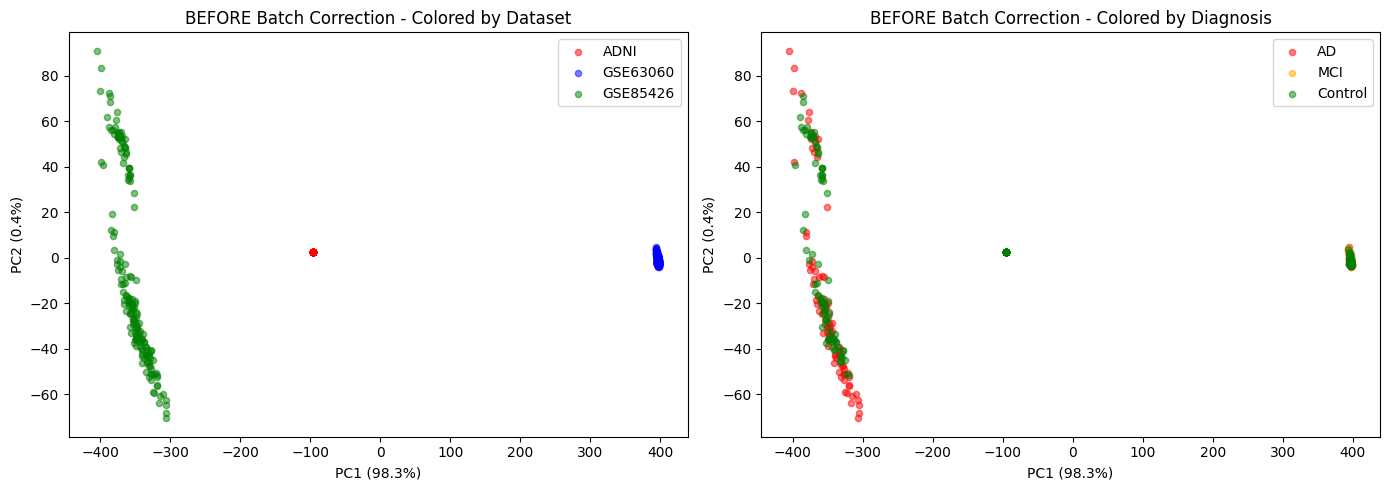

Plot saved as batch_effects_before.png


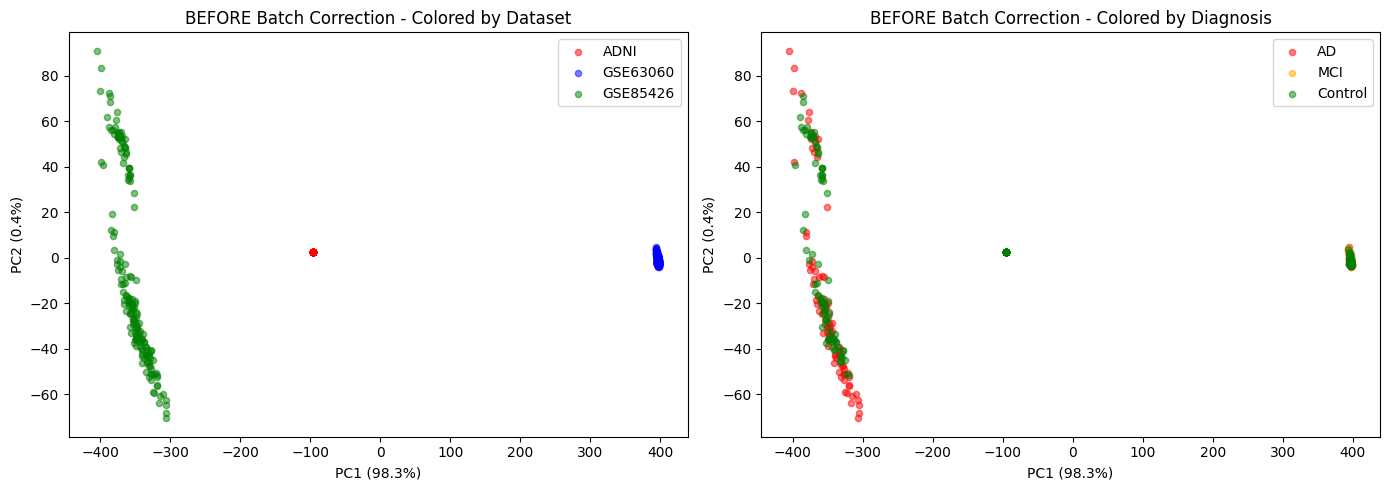

Plot saved as batch_effects_before.png


In [200]:
# Visualize batch effects before correction

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reset index on combined_expr to align with phenotype
combined_expr = combined_expr.reset_index(drop=True)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_expr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot by Dataset (batch)
colors_dataset = {'ADNI': 'red', 'GSE63060': 'blue', 'GSE85426': 'green'}
for dataset in ['ADNI', 'GSE63060', 'GSE85426']:
    mask = combined_pheno['Dataset'] == dataset
    axes[0].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   c=colors_dataset[dataset], label=dataset, alpha=0.5, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('BEFORE Batch Correction - Colored by Dataset')
axes[0].legend()

# Plot by Diagnosis
colors_diag = {'AD': 'red', 'MCI': 'orange', 'Control': 'green'}
for diag in ['AD', 'MCI', 'Control']:
    mask = combined_pheno['Diagnosis'] == diag
    axes[1].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   c=colors_diag[diag], label=diag, alpha=0.5, s=20)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('BEFORE Batch Correction - Colored by Diagnosis')
axes[1].legend()

plt.tight_layout()
plt.savefig('batch_effects_before.png', dpi=150)
plt.show()

print("Plot saved as batch_effects_before.png")# Visualize batch effects before correction

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reset index on combined_expr to align with phenotype
combined_expr = combined_expr.reset_index(drop=True)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_expr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot by Dataset (batch)
colors_dataset = {'ADNI': 'red', 'GSE63060': 'blue', 'GSE85426': 'green'}
for dataset in ['ADNI', 'GSE63060', 'GSE85426']:
    mask = combined_pheno['Dataset'] == dataset
    axes[0].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   c=colors_dataset[dataset], label=dataset, alpha=0.5, s=20)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('BEFORE Batch Correction - Colored by Dataset')
axes[0].legend()

# Plot by Diagnosis
colors_diag = {'AD': 'red', 'MCI': 'orange', 'Control': 'green'}
for diag in ['AD', 'MCI', 'Control']:
    mask = combined_pheno['Diagnosis'] == diag
    axes[1].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   c=colors_diag[diag], label=diag, alpha=0.5, s=20)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('BEFORE Batch Correction - Colored by Diagnosis')
axes[1].legend()

plt.tight_layout()
plt.savefig('batch_effects_before.png', dpi=150)
plt.show()

print("Plot saved as batch_effects_before.png")

In [201]:
# Apply ComBat batch correction

# Install pycombat if needed
import subprocess
subprocess.run(['pip', 'install', 'combat', '-q'])

from combat.pycombat import pycombat

print("Applying ComBat batch correction...")
print(f"Expression matrix shape: {combined_expr.shape}")
print(f"Batch labels: {pd.Series(dataset_labels).value_counts().to_dict()}")

# ComBat expects genes as rows, samples as columns
expr_for_combat = combined_expr.T

print(f"\nTransposed shape for ComBat: {expr_for_combat.shape}")

# Apply ComBat
expr_corrected = pycombat(expr_for_combat, dataset_labels)

# Transpose back to samples as rows
combined_expr_corrected = expr_corrected.T

print(f"\nCorrected expression shape: {combined_expr_corrected.shape}")
print("ComBat correction complete!")

Applying ComBat batch correction...
Expression matrix shape: (1209, 7617)
Batch labels: {'ADNI': 700, 'GSE63060': 329, 'GSE85426': 180}

Transposed shape for ComBat: (7617, 1209)
Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data

Corrected expression shape: (1209, 7617)
ComBat correction complete!


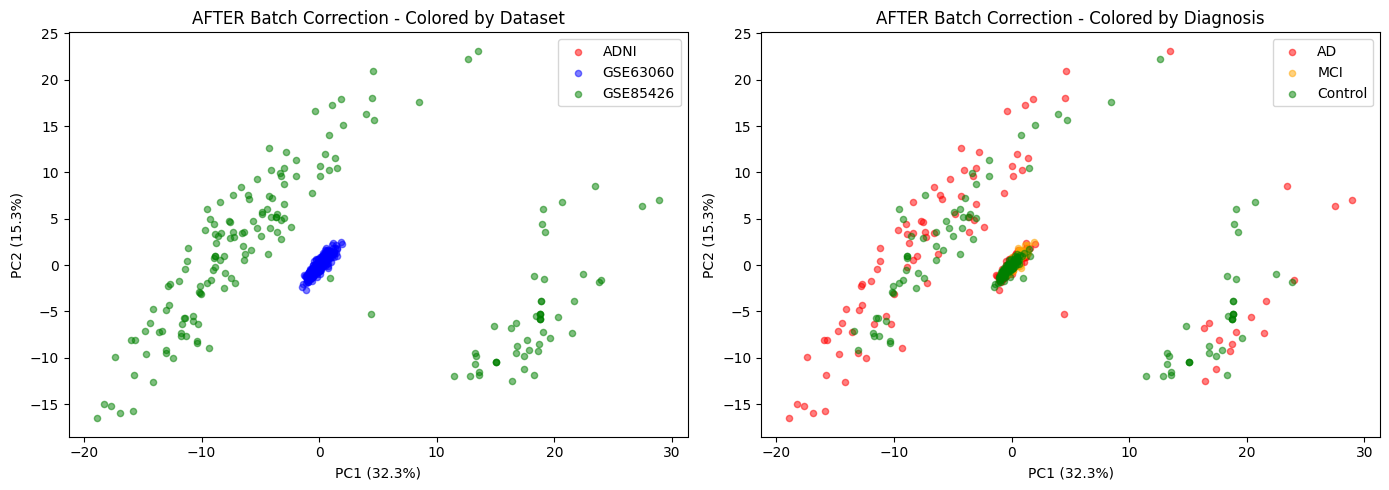

Plot saved as batch_effects_after.png


In [202]:
# Visualize after batch correction

# PCA on corrected data
pca_corrected = PCA(n_components=2)
pca_result_corrected = pca_corrected.fit_transform(combined_expr_corrected)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot by Dataset (batch)
for dataset in ['ADNI', 'GSE63060', 'GSE85426']:
    mask = combined_pheno['Dataset'] == dataset
    axes[0].scatter(pca_result_corrected[mask, 0], pca_result_corrected[mask, 1], 
                   c=colors_dataset[dataset], label=dataset, alpha=0.5, s=20)
axes[0].set_xlabel(f'PC1 ({pca_corrected.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca_corrected.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('AFTER Batch Correction - Colored by Dataset')
axes[0].legend()

# Plot by Diagnosis
for diag in ['AD', 'MCI', 'Control']:
    mask = combined_pheno['Diagnosis'] == diag
    axes[1].scatter(pca_result_corrected[mask, 0], pca_result_corrected[mask, 1], 
                   c=colors_diag[diag], label=diag, alpha=0.5, s=20)
axes[1].set_xlabel(f'PC1 ({pca_corrected.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca_corrected.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('AFTER Batch Correction - Colored by Diagnosis')
axes[1].legend()

plt.tight_layout()
plt.savefig('batch_effects_after.png', dpi=150)
plt.show()

print("Plot saved as batch_effects_after.png")

In [203]:
# Quantile normalization

from sklearn.preprocessing import quantile_transform

print("Applying quantile normalization...")

# Quantile normalize (samples as rows, genes as columns)
expr_normalized = quantile_transform(combined_expr_corrected, 
                                      n_quantiles=1000, 
                                      output_distribution='normal',
                                      random_state=42)

combined_expr_final = pd.DataFrame(expr_normalized, 
                                    columns=combined_expr_corrected.columns,
                                    index=combined_expr_corrected.index)

print(f"Normalized expression shape: {combined_expr_final.shape}")
print(f"Value range: {combined_expr_final.values.min():.2f} to {combined_expr_final.values.max():.2f}")

# Check for NaN
nan_count = combined_expr_final.isna().sum().sum()
print(f"NaN values: {nan_count}")

# Summary stats
print(f"\nMean of means: {combined_expr_final.mean().mean():.4f}")
print(f"Std of means: {combined_expr_final.mean().std():.4f}")

Applying quantile normalization...
Normalized expression shape: (1209, 7617)
Value range: -5.20 to 5.20
NaN values: 0

Mean of means: -0.0001
Std of means: 0.0006


In [204]:

# Feature selection using XGBoost

from xgboost import XGBClassifier
import numpy as np
import pandas as pd

label_map = {'Control': 0, 'MCI': 1, 'AD': 2}

y = combined_pheno['Diagnosis'].map(label_map)

# keep only rows with valid labels AND present in expression
valid_idx = y.dropna().index.intersection(combined_expr_final.index)

X = combined_expr_final.loc[valid_idx].copy()
y = y.loc[valid_idx].astype(int).values

print("Valid samples for feature selection:", len(y))
print("Label counts:", pd.Series(y).value_counts().to_dict())

# 1) Remove low variance genes (bottom 20%)
variances = X.var()
variance_threshold = variances.quantile(0.2)
high_var_genes = variances[variances > variance_threshold].index.tolist()
print(f"After variance filtering: {len(high_var_genes)} genes (removed bottom 20%)")

X_high_var = X[high_var_genes]

# 2) XGBoost feature importance
print("\nTraining XGBoost for feature selection...")

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    objective="multi:softprob",
    num_class=3
)

xgb.fit(X_high_var, y)

importances = xgb.feature_importances_
feature_scores = pd.DataFrame({"gene": high_var_genes, "importance": importances}) \
    .sort_values("importance", ascending=False)

print("\nTop 20 genes by XGBoost importance:")
print(feature_scores.head(20))

N_FEATURES = 1000
top_genes = feature_scores.head(N_FEATURES)["gene"].tolist()
print(f"\nSelected top {N_FEATURES} genes for final dataset")

nonzero = (feature_scores["importance"] > 0).sum()
print(f"Genes with non-zero importance: {nonzero}")


Valid samples for feature selection: 1209
Label counts: {1: 519, 0: 455, 2: 235}
After variance filtering: 6093 genes (removed bottom 20%)

Training XGBoost for feature selection...

Top 20 genes by XGBoost importance:
         gene  importance
974     CMTM2    0.010863
637    CAPNS1    0.008736
3569    PAIP2    0.006860
3461     OAZ1    0.005387
5509    TTC31    0.005313
5358  TNFSF14    0.005182
989     CNOT8    0.004838
2236    HMGN4    0.004193
3264   NDUFB3    0.004169
4900   SPRR1A    0.003999
1608    EXOC3    0.003959
3939    PPTC7    0.003353
951     CLIC1    0.003264
4953    SSU72    0.002964
4407    RTBDN    0.002806
1200    CYTH4    0.002763
4908   SPTAN1    0.002707
1341   DNAJA1    0.002580
602       C8G    0.002493
4020    PSMB8    0.002447

Selected top 1000 genes for final dataset
Genes with non-zero importance: 2902


In [205]:
# Create final dataset

# Select top genes
final_expr = combined_expr_final[top_genes].copy()
print(f"Final expression shape: {final_expr.shape}")

# Add phenotype data
final_dataset = final_expr.copy()
final_dataset['Age'] = combined_pheno['Age'].values
final_dataset['Sex'] = combined_pheno['Sex'].values
final_dataset['Diagnosis'] = combined_pheno['Diagnosis'].values
final_dataset['Dataset'] = combined_pheno['Dataset'].values

# Standardize Age
final_dataset['Age'] = pd.to_numeric(final_dataset['Age'], errors='coerce')
age_mean = final_dataset['Age'].mean()
age_std = final_dataset['Age'].std()
final_dataset['Age_Zscore'] = (final_dataset['Age'] - age_mean) / age_std

# Encode Sex
final_dataset['Sex'] = final_dataset['Sex'].str.lower().str.strip()
final_dataset['Sex_Male'] = (final_dataset['Sex'].isin(['male', 'm'])).astype(int)

# Check for missing values
print(f"\nMissing values:")
print(f"  Age: {final_dataset['Age'].isna().sum()}")
print(f"  Sex: {final_dataset['Sex'].isna().sum()}")
print(f"  Diagnosis: {final_dataset['Diagnosis'].isna().sum()}")

# Fill missing Age with median
if final_dataset['Age'].isna().sum() > 0:
    final_dataset['Age'] = final_dataset['Age'].fillna(final_dataset['Age'].median())
    final_dataset['Age_Zscore'] = (final_dataset['Age'] - age_mean) / age_std

print(f"\nFinal dataset shape: {final_dataset.shape}")
print(f"\nDiagnosis distribution:")
print(final_dataset['Diagnosis'].value_counts())
print(f"\nDataset distribution:")
print(final_dataset['Dataset'].value_counts())
print(f"\nSex distribution:")
print(final_dataset['Sex_Male'].value_counts())

Final expression shape: (1209, 1000)

Missing values:
  Age: 0
  Sex: 0
  Diagnosis: 0

Final dataset shape: (1209, 1006)

Diagnosis distribution:
Diagnosis
MCI        519
Control    455
AD         235
Name: count, dtype: int64

Dataset distribution:
Dataset
ADNI        700
GSE63060    329
GSE85426    180
Name: count, dtype: int64

Sex distribution:
Sex_Male
0    607
1    602
Name: count, dtype: int64


In [206]:
# Save final dataset

# Create output directory
import os
os.makedirs('output', exist_ok=True)

# Save full dataset with all info
final_dataset.to_csv('output/Final_Dataset_BatchCorrected.csv', index=False)
print(f"Saved: output/Final_Dataset_BatchCorrected.csv")
print(f"  Shape: {final_dataset.shape}")

# Save version for modeling (without raw Age and Sex columns)
model_cols = top_genes + ['Age_Zscore', 'Sex_Male', 'Diagnosis', 'Dataset']
model_dataset = final_dataset[model_cols].copy()
model_dataset.to_csv('output/Final_Dataset_ForModeling.csv', index=False)
print(f"\nSaved: output/Final_Dataset_ForModeling.csv")
print(f"  Shape: {model_dataset.shape}")
print(f"  Features: {len(top_genes)} genes + Age_Zscore + Sex_Male")
print(f"  Target: Diagnosis")
print(f"  Batch info: Dataset")

# Save gene list
pd.DataFrame({'gene': top_genes, 'importance': feature_scores.head(N_FEATURES)['importance'].values}).to_csv(
    'output/Selected_Genes.csv', index=False)
print(f"\nSaved: output/Selected_Genes.csv")

# Summary
print(f"\nFinal dataset:")
print(f"  Samples: {len(final_dataset)}")
print(f"  Features: {len(top_genes)} genes + 2 covariates")
print(f"  Classes: AD ({(final_dataset['Diagnosis']=='AD').sum()}), "
      f"MCI ({(final_dataset['Diagnosis']=='MCI').sum()}), "
      f"Control ({(final_dataset['Diagnosis']=='Control').sum()})")
print(f"\nDatasets combined:")
print(f"  ADNI: {(final_dataset['Dataset']=='ADNI').sum()} samples")
print(f"  GSE63060: {(final_dataset['Dataset']=='GSE63060').sum()} samples")
print(f"  GSE85426: {(final_dataset['Dataset']=='GSE85426').sum()} samples")
print(f"\nBatch correction: ComBat applied")
print(f"Normalization: Quantile normalization applied")
print(f"Feature selection: XGBoost (top 1000 genes)")

Saved: output/Final_Dataset_BatchCorrected.csv
  Shape: (1209, 1006)

Saved: output/Final_Dataset_ForModeling.csv
  Shape: (1209, 1004)
  Features: 1000 genes + Age_Zscore + Sex_Male
  Target: Diagnosis
  Batch info: Dataset

Saved: output/Selected_Genes.csv

Final dataset:
  Samples: 1209
  Features: 1000 genes + 2 covariates
  Classes: AD (235), MCI (519), Control (455)

Datasets combined:
  ADNI: 700 samples
  GSE63060: 329 samples
  GSE85426: 180 samples

Batch correction: ComBat applied
Normalization: Quantile normalization applied
Feature selection: XGBoost (top 1000 genes)


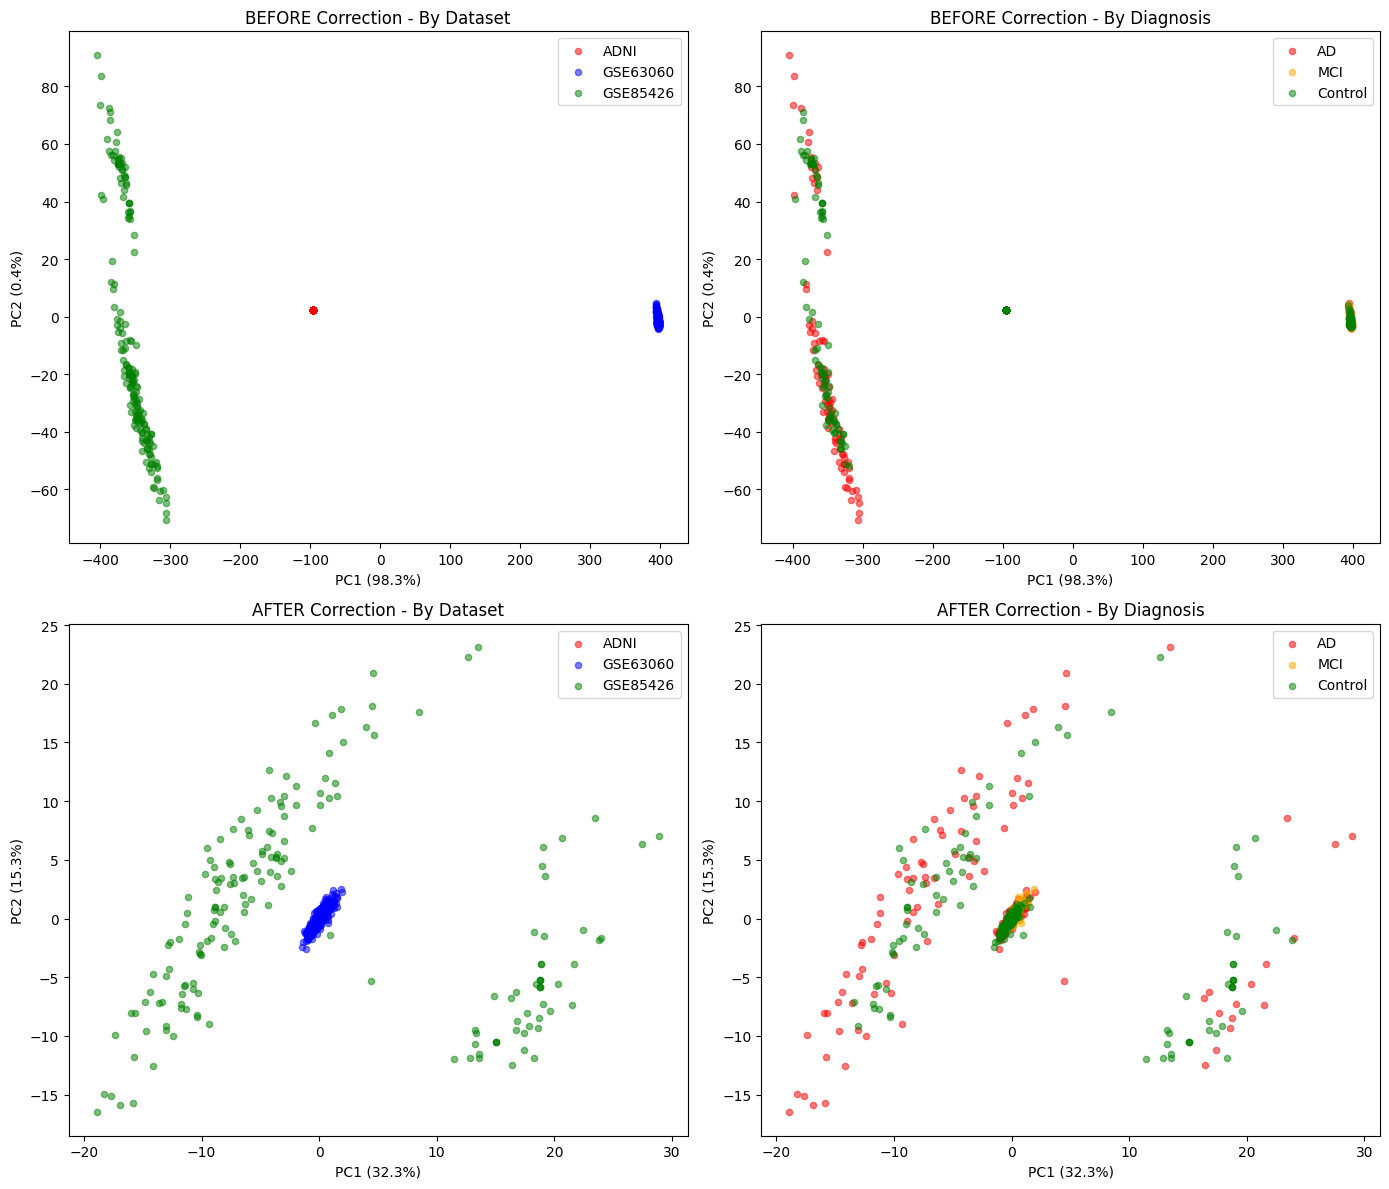

Saved: output/Batch_Correction_Comparison.png


In [207]:
# Final comparison plot - Before vs After

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# BEFORE - by Dataset
for dataset in ['ADNI', 'GSE63060', 'GSE85426']:
    mask = combined_pheno['Dataset'] == dataset
    axes[0,0].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   c=colors_dataset[dataset], label=dataset, alpha=0.5, s=20)
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0,0].set_title('BEFORE Correction - By Dataset')
axes[0,0].legend()

# BEFORE - by Diagnosis
for diag in ['AD', 'MCI', 'Control']:
    mask = combined_pheno['Diagnosis'] == diag
    axes[0,1].scatter(pca_result[mask, 0], pca_result[mask, 1], 
                   c=colors_diag[diag], label=diag, alpha=0.5, s=20)
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0,1].set_title('BEFORE Correction - By Diagnosis')
axes[0,1].legend()

# AFTER - by Dataset
for dataset in ['ADNI', 'GSE63060', 'GSE85426']:
    mask = combined_pheno['Dataset'] == dataset
    axes[1,0].scatter(pca_result_corrected[mask, 0], pca_result_corrected[mask, 1], 
                   c=colors_dataset[dataset], label=dataset, alpha=0.5, s=20)
axes[1,0].set_xlabel(f'PC1 ({pca_corrected.explained_variance_ratio_[0]*100:.1f}%)')
axes[1,0].set_ylabel(f'PC2 ({pca_corrected.explained_variance_ratio_[1]*100:.1f}%)')
axes[1,0].set_title('AFTER Correction - By Dataset')
axes[1,0].legend()

# AFTER - by Diagnosis
for diag in ['AD', 'MCI', 'Control']:
    mask = combined_pheno['Diagnosis'] == diag
    axes[1,1].scatter(pca_result_corrected[mask, 0], pca_result_corrected[mask, 1], 
                   c=colors_diag[diag], label=diag, alpha=0.5, s=20)
axes[1,1].set_xlabel(f'PC1 ({pca_corrected.explained_variance_ratio_[0]*100:.1f}%)')
axes[1,1].set_ylabel(f'PC2 ({pca_corrected.explained_variance_ratio_[1]*100:.1f}%)')
axes[1,1].set_title('AFTER Correction - By Diagnosis')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('output/Batch_Correction_Comparison.png', dpi=150)
plt.show()

print("Saved: output/Batch_Correction_Comparison.png")